In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE

from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model


# Set random seed
np.random.seed(0)

In [9]:
from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros

In [10]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

<a id='scrape'></a>
## Импорт датасета

In [73]:
import pandas as pd
df = pd.read_csv('USD_RUB.csv', sep=",")
df.date = pd.to_datetime(df.Date)
df = df.set_index('Date').interpolate().drop(columns=['Open', 'High', 'Low', 'Change %'])
print(df.isna().sum())
df = df.copy().dropna(axis=0)
rate_data = df.iloc[::-1]
rate_data = rate_data[3800:5250]

Price    0
dtype: int64


<ipython-input-73-8983486cd661>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.date = pd.to_datetime(df.Date)


<a id='viz'></a>
## Визуализация данных

In [74]:
rate_data.head()

,Price
Date,
Apr 13 2016,66.2975
Apr 14 2016,66.1361
Apr 15 2016,66.4050
Apr 18 2016,66.0847
Apr 19 2016,65.8547


In [76]:
rate_data.tail()

,Price
Date,
Dec 30 2021,74.6539
Jan 03 2022,74.5508
Jan 04 2022,75.3700
Jan 05 2022,76.7857
Jan 06 2022,76.3130


In [77]:
rate_data.describe()

,Price
count,1450.000000
mean,66.162735
std,6.222516
min,55.713400
25%,61.971500
50%,65.132100
75%,72.763250
max,80.869200


Все данные находятся в диапазоне от 55,7 до 80,8 в пределах интервала. Среднее значение и стандартное отклонение близки, что указывает на то, что экстремальных значений либо нет, либо, даже если они есть, они сбалансированы одинаково с обеих сторон данных. По этой причине только квартильных и средних данных недостаточно, чтобы получить представление о распределении данных, необходимо построить гистограмму.

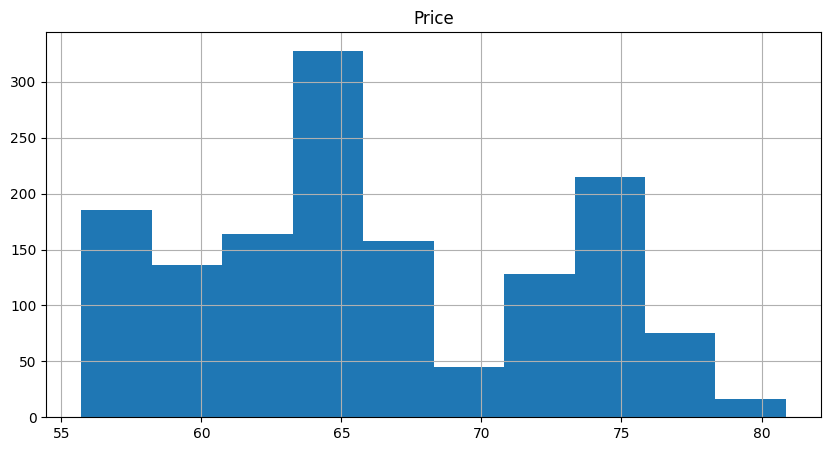

In [78]:
# Plot a histogram
rate_data.hist()
plt.show()

Из гистограммы видно, что значения появляются с наибольшей частотой около 65. Однако существует также огромная частота в диапазоне 73-75. Поскольку ряд является временным рядом, он говорит о том, что значения были постоянными в районе 65 в течение длительного времени, внезапно подскочили примерно до 73, оставались в диапазоне 73-75 в течение некоторого времени.

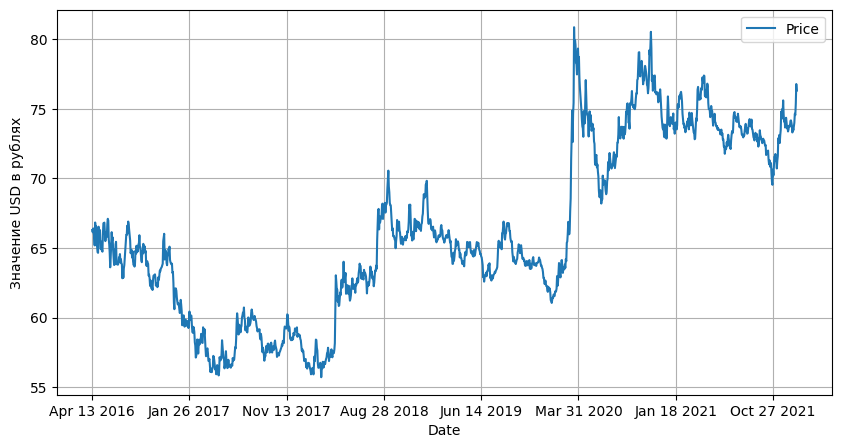

In [79]:
plt.rcParams["figure.figsize"] = fig_size
rate_data.plot()
plt.ylabel('Значение USD в рублях')
plt.grid()

<a id='stat'></a>
## Анализ стационарности

<p> <font style="FONT-SIZE:15px; COLOR:#000000; LINE-HEIGHT:25px; FONT-FAMILY:Arial,Helvetica,sans-serif">
&emsp;&emsp;Временной ряд называется стационарным, если его среднее значение, дисперсия и структура автокорреляции постоянны относительно временного горизонта ряда. В стационарном временном ряду тенденции не влияют на распознавание закономерностей в данных, поскольку мы начинаем с устранения тренда. Следовательно, прогнозировать стационарный временной ряд легче, чем нестационарный. Практически невозможно получить ряд, который был бы полностью стационарным. По этой причине при анализе временных рядов стационарный ряд относится к слабостационарному ряду, и многие модели прогнозирования основаны на предположении о слабой стационарности. Существуют определенные преобразования, которые реализуются для приведения нестационарного временного ряда в слабостационарную форму.<br>


### Преобразования ряда в слабостационарный

<p> <font style="FONT-SIZE:15px; COLOR:#000000; LINE-HEIGHT:25px; FONT-FAMILY:Arial,Helvetica,sans-serif">
&emsp;&emsp; Слабая стационарность требует, чтобы все корни авторегрессионного запаздывающего многочлена были больше единицы. Если они равны или меньше единицы, наше предположение о стационарности не выполняется. Мы используем расширенный тест Дики-Фуллера (ADF) для проверки стационарности преобразованного ряда. ADF проверяет нулевую гипотезу о том, что ряд имеет единичный корень. Следовательно, после выполнения проверки гипотезы показатели, возвращаемые ADF, которые говорят в нашу пользу (те, которые указывают на стационарность), являются: <br>
    &emsp;&emsp;1. Высокое абсолютное значение t-статистики (предпочтительно выше критического значения в 1%) <br>
    &emsp;&emsp;2. Значение 'p-value' очень близко к нулю. <br>

In [80]:
# ADF test on raw data (without transformation)

df_test = adfuller(rate_data['Price'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                   -1.171938
p-value                           0.685549
#Lags Used                        3.000000
Number of Observations Used    1446.000000
Critical Value (1%)              -3.434880
Critical Value (5%)              -2.863541
Critical Value (10%)             -2.567835
dtype: float64


#### Итог:
1. Абсолютное значение t-статистики намного больше любого критического значения. <br>
2. значение p очень близко к 1, а не к 0. <br><br>
Следовательно, мы принимаем нулевую гипотезу. Другими словами, этот ряд далек от стационарности.<br>


### Приводим к стационарности

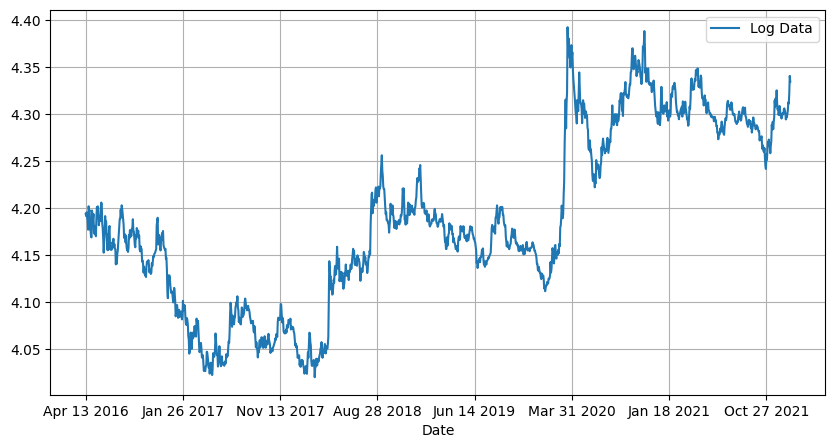

In [81]:
# Calculate and plot logarithm of the data
rate_data_log=np.log(rate_data['Price'])
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

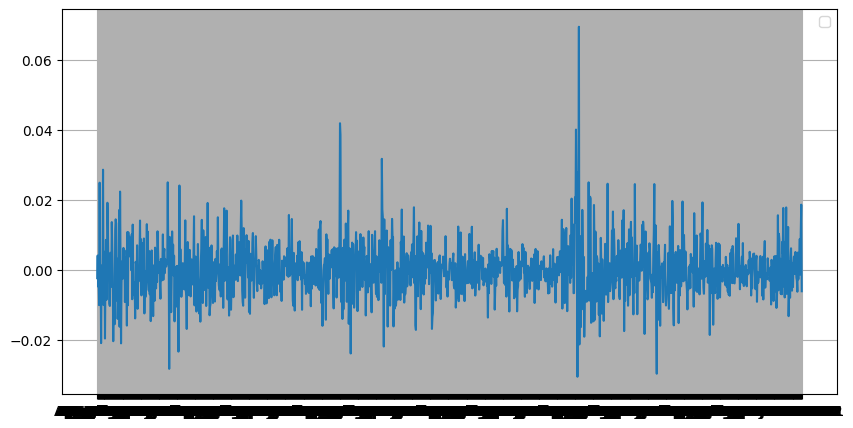

In [82]:
# Calculate and plot the first order differnece

rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [83]:
# Perform ADF test

df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                  -23.055448
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1446.000000
Critical Value (1%)              -3.434880
Critical Value (5%)              -2.863541
Critical Value (10%)             -2.567835
dtype: float64


#### Итог:
1. Значение t-статистики намного меньше любого из критических значений.<br>
2. Значение p равно нулю.<br><br>


<a id='model'></a>
## Предсказывание значений

<a id='arima'></a>
#### Autoregressive Integrated Moving Average (ARIMA)

In [84]:
rate_data_log

Date
Apr 13 2016    4.194152
Apr 14 2016    4.191715
Apr 15 2016    4.195772
Apr 18 2016    4.190937
Apr 19 2016    4.187451
                 ...   
Dec 30 2021    4.312863
Jan 03 2022    4.311481
Jan 04 2022    4.322409
Jan 05 2022    4.341018
Jan 06 2022    4.334843
Name: Price, Length: 1450, dtype: float64

In [85]:
data1 = rate_data_log.values
train_size = int(len(data1) * 0.80)
train = list(data1[0:train_size])
train_ = list(data1[0:train_size])
test = list(data1[train_size:])
otest = list(data1[train_size:0])

train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [86]:
model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
full_predictions=float(fit.forecast()[0])

Mean squared error: 0.215888


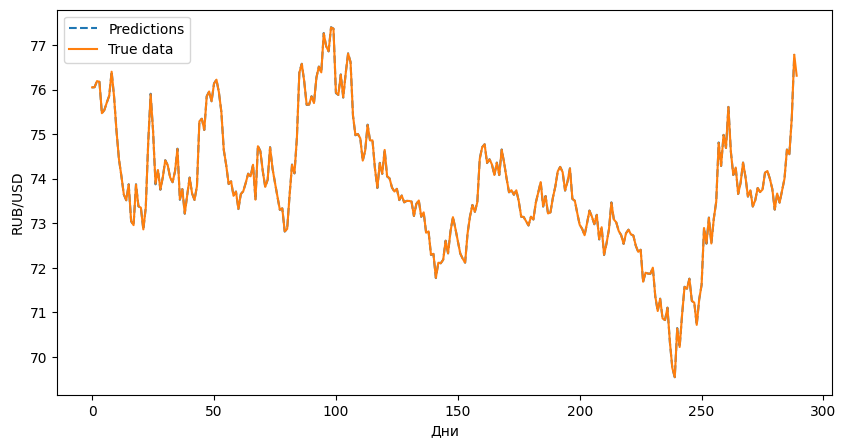

In [87]:
plt.plot(np.exp(predictions)[1:],'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('RUB/USD')
plt.xlabel('Дни')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

In [88]:
#Значение завтра
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])

tomorrow_value = np.exp(forecast)

#Значение сегодня

rate_data_log = rate_data_log[:-1]
data1 = rate_data_log.values
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])
today_value = np.exp(forecast)

In [89]:
rate_data.tail()

,Price
Date,
Dec 30 2021,74.6539
Jan 03 2022,74.5508
Jan 04 2022,75.3700
Jan 05 2022,76.7857
Jan 06 2022,76.3130


In [90]:
print ("Реальное значение сегодня - {0:3f}, предсказанное - {1:3f}.".format(rate_data.values[-1][0],today_value))
print ("Предсказанное значение на завтра - {0:3f}.".format(tomorrow_value))

Реальное значение сегодня - 76.313000, предсказанное - 76.791905.
Предсказанное значение на завтра - 76.311567.


#### Предсказания на все дни в выборке

In [108]:
train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(forecast))



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Mean squared error: 7.443427


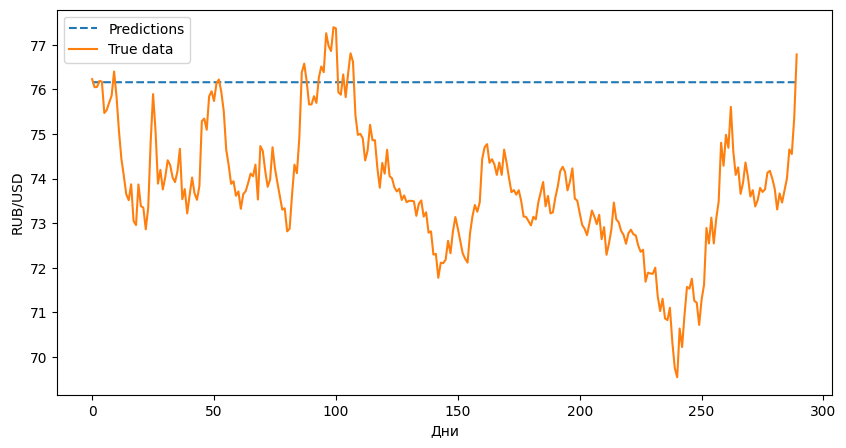

In [109]:
# predictions = fit.forecast(len(test))[0]
plt.plot(np.exp(predictions),'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('RUB/USD')
plt.xlabel('Дни')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

Поскольку ARIMA является линейной моделью, прогнозирование с использованием ARIMA на срок более 1 дня совершенно неэффективно.
Модель продолжает восходящий тренд до бесконечности.

<a id='rnn'></a>
### LSTM- Recurrent Neural Network (LSTM-RNN)

In [93]:
data1 = rate_data_log.values
train_size = int(len(data1) * 0.80)
train = list(data1[0:train_size])
test = list(data1[train_size:])

In [94]:
def gen_XY(t_list,size):
    '''
    Generates an autoregressive lagged array.

    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.

    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.

    '''
    X = np.zeros([1,size])
    Y = []
    temp_list=[]
    for i in range(len(t_list)-size):
        add_list = t_list[i:i+size]
        target = t_list[i+size]
        X = np.append(X,np.array([add_list]),axis=0)
        Y.append(target)

    X = np.delete(X,0,axis=0)
    Y = np.array(Y)

    return X,Y.T

In [95]:
X_train,y_train = gen_XY(train,1)
X_test,y_test = gen_XY(test,1)

In [96]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [97]:
X_tr_t.shape

(1158, 1, 1)

In [98]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(10,input_shape=(1, X_train.shape[1]), activation='relu'))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1158/1158 [==============================] - 6s 4ms/step - loss: 0.5679
Epoch 2/200
1158/1158 [==============================] - 3s 3ms/step - loss: 7.3089e-05
Epoch 3/200
1158/1158 [==============================] - 4s 3ms/step - loss: 7.6281e-05
Epoch 4/200
1158/1158 [==============================] - 5s 4ms/step - loss: 8.2054e-05
Epoch 5/200
1158/1158 [==============================] - 4s 3ms/step - loss: 9.5769e-05
Epoch 6/200
1158/1158 [==============================] - 3s 3ms/step - loss: 1.2267e-04
Epoch 7/200
1158/1158 [==============================] - 4s 3ms/step - loss: 1.3922e-04
Epoch 7: early stopping


In [99]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The MSE on the Train set is:\t{:0.3f}".format(MSE(np.exp(y_train), np.exp(y_train_pred_lstm))))
print("The MSE on the Test set is:\t{:0.3f}".format(MSE(np.exp(y_test), np.exp(y_pred_test_lstm))))

37/37 [==============================] - 0s 4ms/step
The MSE on the Train set is:	6.066
The MSE on the Test set is:	3.274


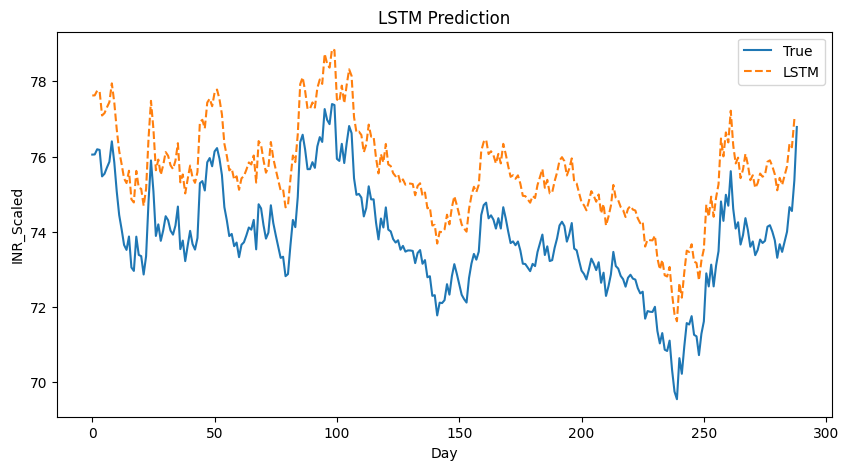

In [100]:
plt.plot(np.exp(y_test), label='True')
plt.plot(np.exp(y_pred_test_lstm)[1:],'--',label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Day')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

До сих пор мы прогнозировали только прогноз на один день вперед. Естественно, почему вас должно интересовать только прогнозирование стоимости завтрашнего дня? Однако ошибка распространяется очень быстро при прогнозировании во временных рядах, особенно в одномерном сценарии, таком как этот. В некоторых случаях, скажем, если частота повторяется ежегодно, даже прогноз на один шаг вперед может дать много информации. <br><br>
Но в данном случае давайте посмотрим, насколько точен 3-недельный прогноз на основе тестовых данных.

<a id='multistep'></a>
### Пердсказания на несколько дней вперед

In [101]:
data1 = rate_data_log.values
train = list(data1[0:train_size])
test = list(data1[train_size:])

In [102]:
X_train,y_train = gen_XY(train,10)
# X_test,y_test = gen_XY(test,10)

In [103]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [104]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(5, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(5,input_shape=(1, X_train.shape[1]), activation='relu'))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
1149/1149 [==============================] - 5s 3ms/step - loss: 0.5509
Epoch 2/200
1149/1149 [==============================] - 3s 3ms/step - loss: 5.0929e-04
Epoch 3/200
1149/1149 [==============================] - 4s 3ms/step - loss: 5.9634e-04
Epoch 4/200
1149/1149 [==============================] - 4s 4ms/step - loss: 6.3731e-04
Epoch 5/200
1149/1149 [==============================] - 3s 3ms/step - loss: 6.2071e-04
Epoch 6/200
1149/1149 [==============================] - 3s 3ms/step - loss: 5.1321e-04
Epoch 7/200
1149/1149 [==============================] - 4s 3ms/step - loss: 3.7912e-04
Epoch 8/200
1149/1149 [==============================] - 4s 3ms/step - loss: 2.9375e-04
Epoch 9/200
1149/1149 [==============================] - 3s 3ms/step - loss: 2.3815e-04
Epoch 10/200
1149/1149 [==============================] - 3s 3ms/step - loss: 2.2673e-04
Epoch 11/200
1149/1149 [==============================] - 4s 3ms/step - loss: 2.2741e-04
Epoch 12/200
1149/1149 [==========

In [105]:
test_array = X_tr_t[-1][0]
pred = []
forecast_length = len(test)
for i in range(forecast_length):
    y_train_pred_lstm = model_lstm.predict(test_array.reshape(1,1,10))
    pred.append(y_train_pred_lstm[0][0])
    test_array = np.append(test_array[1:],y_train_pred_lstm[0][0])

1/1 [==============================] - 0s 22ms/step


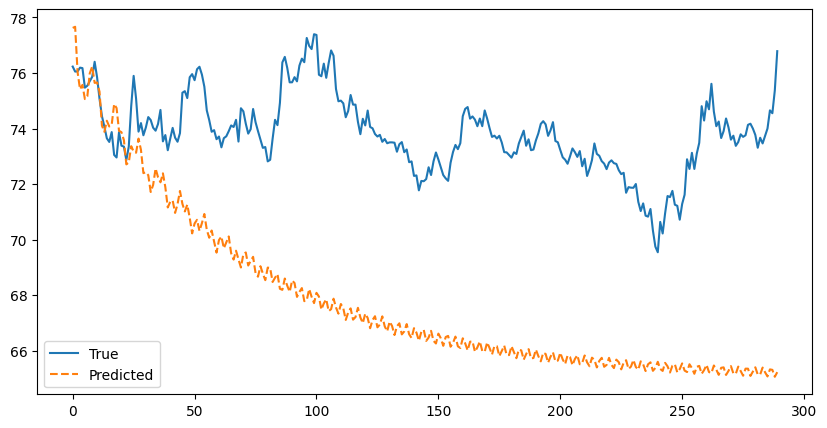

In [106]:
plt.plot(np.exp(test),label='True')
plt.plot(np.exp(pred),'--',label='Predicted')
plt.legend()
plt.show()

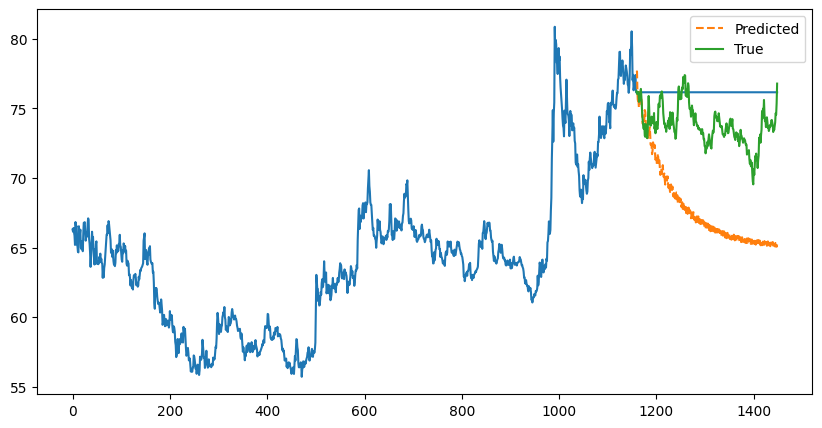

43.19630690967806

In [113]:
plt.plot(np.exp(train))
plt.plot(range(train_size,len(data1)),np.exp(pred),'--',label='Predicted')
plt.plot(range(train_size,len(data1)),np.exp(test),label='True')
plt.legend()
plt.show()
MSE(np.exp(test),np.exp(pred))